### Hello!
#### Welcome to our CAM jupyter notebook. The code here is designed to help individuals interested in quantitative comparison's of CAMs. 

# 1) Getting Data
#### This section will pull data into jupyter notebook and load all the dependencies you will need.

In [1]:
import re
import numpy as np
import pandas as pd
import os
from os import walk
import math

import cv2 as cv
import networkx as nx

import chart_studio.plotly as py
import plotly.offline as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
#from Shapes import shapes
#from Lines import lines


### 1.A) Pulling Data from File
Data shouls be stored according to the 'clean' format listed in data cleaning scripts

In [2]:
#make sure your file path is in quotations
my_filepath = 'Your filepath to data on local computer here'

### 1.B) Create functions to generate a unique list of ids from file names

In [4]:
#Function to get unique elements from a list
def list_unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
            
    return unique_list

In [5]:
def make_id_list(my_file_path):

    #pull all filenames in your data directory
    _, _, filenames = next(walk(my_file_path))

    #grab only the id from the filenames to feed to the function
    id_list = []
    for filename in filenames:
        filename_split = filename.rsplit('_', 1)
        id_list.append(filename_split[0])
    
    unique_id = list_unique(id_list) #drop duplicate ids, since they are the same for _blocks & _links
        
    
    
    return unique_id

### 1.C) Apply the previous two functions to your file path

In [6]:
# Get an id_list from your specific file path
my_id_list = make_id_list(my_filepath)

In [7]:
#Look at total number of cams
print(f'The total number of cams = {len(my_id_list)}')

The total number of cams = 159


# 2) Building Network Graphs
#### The following code will construct network objects that can be viewed and exported for visualizations

### 2.A) Constructing A Single Graph
#### Make sure code is running correctly before generating all network objects

In [8]:
cam_id = my_id_list[0] #grab a single id to just look through code

blocks = pd.read_csv(f'{my_filepath}/{cam_id}_blocks.csv')
links = pd.read_csv(f'{my_filepath}/{cam_id}_links.csv')

display(blocks.head()) # first 5 rows of node data
display(links.head()) # first 5 rows of edge data

,id,title,x_pos,y_pos,width,height,shape,creator,num,comment,timestamp,modifiable,CAM
0,13570,Tax Discount,252.0,379.0,160.0,120.0,positive strong,709,3.0,NaN,17:59:35,1,817
1,13565,Revenue Netral,51.0,377.0,160.0,120.0,ambivalent,709,2.0,NaN,17:59:50,1,817
2,13577,Support Environment,323.0,20.0,160.0,120.0,positive strong,709,5.0,NaN,18:00:04,1,817
3,13562,Carbon Tax,238.0,123.0,160.0,120.0,neutral,709,1.0,NaN,17:52:37,1,817
4,13574,Green,44.0,20.0,160.0,120.0,positive strong,709,4.0,NaN,18:00:16,1,817


,id,starting_block,ending_block,line_style,creator,num,arrow_type,timestamp,CAM
0,7785,13582,13588,Solid-Weak,709,0,none,17:57:08,817
1,7773,13562,13577,Solid-Weak,709,0,none,17:56:13,817
2,7765,13562,13570,Solid-Weak,709,0,none,17:55:28,817
3,7776,13562,13574,Solid-Weak,709,0,none,17:56:23,817
4,7753,13565,13570,Solid,709,0,none,17:54:56,817


### 2.B) Create A Basic Graph Using Networkx

#### Create a function to build most basic graph

In [9]:
def graph_from_df(node_df, edge_df):
    # Get nodes
    nodes = node_df['id'].to_list()
    
    # Get edges
    edge_start = edge_df['starting_block'].to_list()
    edge_end = edge_df['ending_block'].to_list()
    edges = tuple(zip(edge_start, edge_end))
    
    # Create Graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

#### Pass the dataframes for your nodes and links (created above) and assign to variable called G

In [10]:
G = graph_from_df(blocks,links)

### 2.C) Create a function to add attributes to graph

In [11]:
def add_node_attributes(graph_name, node_df, attr_name): #attr_column_name must be in quotes
    
    blocks_dict = node_df[['id', attr_name]].set_index('id').to_dict()[attr_name]
    
    nx.set_node_attributes(graph_name, blocks_dict, attr_name)
    

In [12]:
def add_link_attributes(graph_name, edge_df, attr_name):
    attr_full_dict = {}
    
    edge_df['unique_link']= list(zip(edge_df['starting_block'], edge_df['ending_block']))
        
    for idx, row in edge_df.iterrows():
        
        attr_dict = {attr_name: row[attr_name]}
        
        attr_full_dict.update({row['unique_link']:attr_dict})
    
    nx.set_edge_attributes(G, attr_full_dict)
    
    
    

### 2.D) Make all the Graphs using functions above
#### Store all graphs in a list

In [13]:
graph_list = [] #This will store your finished graphs.
working_id = [] #Get total number of completed cams
no_data = [] #Catch cams that have no links
missing_cam = [] #Catch ids without cams

for i in my_id_list:
    
    
    try:
        blocks_df = pd.read_csv(f'{my_filepath}/{i}_blocks.csv')

        links_df = pd.read_csv(f'{my_filepath}/{i}_links.csv')
        
        if len(links_df)>0:

            G = graph_from_df(blocks_df, links_df)

            add_node_attributes(G,blocks_df,'title')

            add_node_attributes(G,blocks_df,'shape')

            add_link_attributes(G, links_df, 'line_style')

            graph_list.append(G)
            
            working_id.append(i)

        
        else:
            no_data.append(i)
    
    except:
        
        missing_cam.append(i)
        print(f'CAM {i} does not exist')

print('Summary Info:')
print(f'number of missing cams: {len(missing_cam)}')
print(f'number of cams with no links: {len(no_data)}')
print(f'number of complete cams: {len(working_id)}')


CAM 575ec4be3fc3ac000611df4c__771 does not exist
Summary Info:
number of missing cams: 1
number of cams with no links: 32
number of complete cams: 126


### 2.E) Look at one of the graphs stored in your graph list

Edge Attributes
[(13488, 13519, {'line_style': 'Solid-Strong'}), (13488, 13480, {'line_style': 'Dashed'}), (13480, 13510, {'line_style': 'Solid-Weak'}), (13480, 13485, {'line_style': 'Solid-Weak'}), (13480, 13519, {'line_style': 'Solid'}), (13480, 13537, {'line_style': 'Solid-Strong'}), (13480, 13545, {'line_style': 'Solid-Weak'}), (13480, 13558, {'line_style': 'Solid-Weak'}), (13485, 13510, {'line_style': 'Solid-Strong'}), (13485, 13558, {'line_style': 'Solid'}), (13545, 13537, {'line_style': 'Solid-Strong'})]
-------------------------
Node Attributes
[(13488, {'title': 'Backlash from scary conservatives', 'shape': 'negative weak'}), (13480, {'title': 'Carbon Tax', 'shape': 'neutral'}), (13485, {'title': 'makes people more enviromentally concious', 'shape': 'positive weak'}), (13510, {'title': 'Fresher air', 'shape': 'positive strong'}), (13519, {'title': 'Price of goods could go up', 'shape': 'negative weak'}), (13545, {'title': 'More social service/ environment jobs', 'shape': 'posi

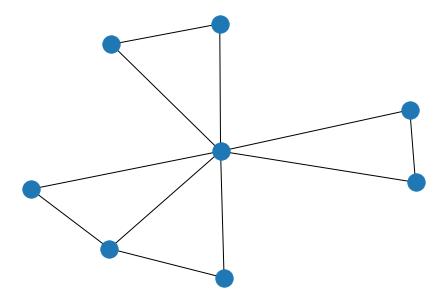

In [14]:
my_graph = graph_list[1]

nx.draw(my_graph)
print('Edge Attributes')
print(my_graph.edges(data = True)) 
print('-------------------------')
print('Node Attributes')
print(my_graph.nodes(data = True))


# 3) Creating Network Measures

### 3.A) Create Functions Calculate Diversity

This methodology can be found on pg 5 of the following paper: https://arxiv.org/pdf/0901.1380.pdf

In [15]:
def calculate_diversity(D, probs):
    """
    Calculate Stirling Diversity measure with alpha = beta = 1
    Args:
        param: D - Distance Matrix
        param: probs - list of probabilities in order of Strong Negative, Negative, Weak Negative, Neutral, Weak Positive, Positive, Strong Positive
    """
    S = 0
    for i in range(7):
        for j in range(7):
            S += D[i, j]*probs[i]*probs[j]
    return S

In [16]:
def get_prob_list(block_df, value_list):
    probs_list = []
    
    for j in range(7):
        x = 0
        for i in range(len(block_df)):
            node = block_df['shape'][i]
            
            if node == 'ambivalent':
                node = 'neutral' 
                
            if node == value_list[j]:
                x = x+1
                
        x = x/len(block_df)
        probs_list.append(x)
    
    return probs_list

### Note:
currently Valience software only permits 7 node types.

In [17]:
# Create distance matrix
D = np.zeros((7,7))  # We have seven node types hence 7 (note that we consider ambivalent as the same as neutral in this calculation)
dist_ = np.arange(7)
for i in range(7):
    D[i,i:] = dist_
    D[i:,i] = dist_
    dist_ = dist_[:-1]

### 3.B) Create Function to Calculate Valence 

In [18]:
def valenceCalc(dataframe):
    
#     Calculate average valence using two methods
#     1 - counting ambivalent nodes once
#     2 - counting ambivalent nodes twice
    
    valence_avg = 0
    if len(dataframe['shape']) > 0:  # If there are any concepts!!
        for valence in dataframe['shape']:
            if valence == 'neutral':
                valence_avg += 0
            elif 'positive' in valence:
                if 'weak' in valence:
                    valence_avg += 1
                elif valence == 'positive':
                    valence_avg += 2
                elif 'strong' in valence:
                    valence_avg += 3
            elif 'negative' in valence:
                if 'weak' in valence:
                    valence_avg -= 1
                elif valence == 'negative':
                    valence_avg -= 2
                elif 'strong' in valence:
                    valence_avg -= 3
        option1 = np.round(valence_avg/len(dataframe['shape']), 2)
        option2 = np.round(valence_avg/(len(dataframe['shape'])+len(dataframe[dataframe['shape'] == 'ambivalent'])), 2)
        return option1, option2
    else:
        return 0, 0

### 3.C) Make lists of node and edge values

In [19]:
# Get a list of node attribute names to loop over
positive_list = ['positive strong', 'positive','positive weak']
negative_list = ['negative strong','negative','negative weak']
neutral_list = ['neutral','ambivalent']
node_val_list = negative_list + neutral_list[:-1] + positive_list

In [20]:
# Get a list of edge attribute names to loop over
solid_list = ['Solid', 'Solid-Strong', 'Solid-Weak']  # Solid link types
dashed_list = ['Dashed', 'Dashed-Strong', 'Dashed-Weak']  # Dashed link types
    

### 3.D) Create function to make data frame of GLI for all CAMs

In [21]:
def calc_CAM_GLI(id_list):
    
    #Create dictionary to hold results
    dictionary_list = []
    
    for cam_id in id_list:
        #Create counter variables
        block_neg = 0
        block_pos = 0
        block_neut = 0
        link_solid = 0
        link_dashed = 0
        
        try:
            df_blocks = pd.read_csv(f'{my_filepath}/{cam_id}_blocks.csv')
            df_links = pd.read_csv(f'{my_filepath}/{cam_id}_links.csv')
            
            #Get proportion of positive and negative nodes
            for i in range(len(df_blocks)):
                
                if df_blocks['shape'][i] in negative_list:
                    block_neg = block_neg + 1
                    
                elif df_blocks['shape'][i] in positive_list:
                    block_pos = block_pos + 1
                    
                else:
                    block_neut = block_neut + 1

            # Get proportion of solid and dashed lines
            for i in range(len(df_links)):
                
                if df_links['line_style'][i] in solid_list:
                    link_solid += 1
                    
                else:
                    link_dashed += 1
            
            # Get probabilities of each type of node -- used for diversity calculation
            neg_strong = df_blocks[df_blocks['shape']=='negative strong'].count()
            neg = df_blocks[df_blocks['shape']=='negative'].count()
            neg_weak = df_blocks[df_blocks['shape']=='negative weak'].count()
            neutral = df_blocks[(df_blocks['shape']=='neutral') & (df_blocks['shape']=='ambivalent')].count()
            pos_weak = df_blocks[df_blocks['shape']=='positive weak'].count()
            pos = df_blocks[df_blocks['shape']=='positive'].count()
            pos_strong = df_blocks[df_blocks['shape']=='positive strong'].count()
            probs = [neg_strong, neg, neg_weak, neutral, pos_weak, pos, pos_strong]
            
            
            #Get diversity measure (Check about prob list)
            try:
                probs = [neg_strong, neg, neg_weak, neutral, pos_weak, pos, pos_strong]
                #probs = get_prob_list(df_blocks, node_val_list)
                div_ = calculate_diversity(D, probs)
            except:
                node_diversity = 999
            
            try:
                node_valence = valenceCalc(df_blocks)
                node_valence_1 = node_valence[0]
                node_valence_2 = node_valence[1]
            except:
                node_valence_1 = 999
                      
            
            # Get nodes
            nodes = df_blocks['id'].to_list()
            
            # Get edges
            edge_start = df_links['starting_block'].to_list()
            edge_end = df_links['ending_block'].to_list()
            edges = tuple(zip(edge_start, edge_end))
            
            # Create Graph
            G = nx.Graph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)
            
            # Calculate Density
            density = np.round(nx.density(G), 3)
            node_count = G.number_of_nodes()
            edge_count = G.size()
            
            # Calculate longest path
            try:
                components = nx.connected_components(G)
                largest_component = max(components, key=len)
                subgraph = G.subgraph(largest_component)
                diameter = nx.diameter(subgraph)
            except:
                diameter = 0
                
            # Calculate transitivity
            triadic_closure = np.round(nx.transitivity(G), 3)
            
            # Calculate max degree
            try:
                degree_centrality = nx.degree_centrality(G)
                max_centrality_ind = np.argmax(list(degree_centrality.values()))
                central_node = list(degree_centrality.keys())[max_centrality_ind]
                central_node_title = df_blocks[df_blocks['id'] == central_node]['title'].values[0]
                central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
            except:
                central_node = 0
                central_node_title = ''
                central_node_val = 0
                
            # Eigenvector Centrality
            try:
                eigenvector_centrality = nx.eigenvector_centrality(G)
                max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
                central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_eig = 0
                
            # Betweeness Centrality
            try:
                betweenness_centrality = nx.betweenness_centrality(G)
                max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
                central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_bet = 0

            # Make the dictionary
                #add in ratio of node val
                #add number of type of node
            density_dict = {
                'cam_id': cam_id,
                'node_count': node_count,
                'edge_count': edge_count,
                'positive_nodes':block_pos,
                'negative_nodes':block_neg,
                'neutral_nodes':block_neut,
                'link_solid': link_solid,
                'link_dashed': link_dashed,
                'node_diversity': div_,
                'node_valence_1': node_valence_1,
                'node_valence_2':node_valence_2,
                'density': density,
                'diameter': diameter,
                'triadic_closure': triadic_closure,
                'central_node': central_node,
                'central_node_title': central_node_title,
                'central_node_val': central_node_val,
                'central_node_val_eig': central_node_val_eig,
                'central_node_val_bet': central_node_val_bet
            }

            dictionary_list.append(density_dict)
            
        except:
            print(f'No file found for {cam_id}') #Return the name of any cams not found
        
    cam_density_df = pd.DataFrame(dictionary_list) #Assign network measures to dataframe
            
    return cam_density_df

### 3.F) Run the function above and assign data frame output to a variable called cam_GLI_df

In [22]:
cam_GLI_df = calc_CAM_GLI(my_id_list)
display(cam_GLI_df)

No file found for 575ec4be3fc3ac000611df4c__771


,cam_id,node_count,edge_count,positive_nodes,negative_nodes,neutral_nodes,link_solid,link_dashed,node_diversity,node_valence_1,node_valence_2,density,diameter,triadic_closure,central_node,central_node_title,central_node_val,central_node_val_eig,central_node_val_bet
0,5f32a496a026e809d7d55cbd_817,7,10,4,1,2,9,1,id 48.0 title 48.0 x_pos ...,1.29,1.12,0.476,2,0.480,13562,Carbon Tax,1.000,0.595,0.667
1,5f67f8d55e7718150fd23bc7_802,8,11,5,2,1,10,1,id 80.0 title 80.0 x_pos ...,0.88,0.88,0.393,2,0.400,13480,Carbon Tax,1.000,0.623,0.786
2,5e45dd10f354ca0c7f4225c7_903,10,9,3,3,4,8,1,id 76.0 title 76.0 x_pos ...,0.00,0.00,0.200,5,0.000,14076,economic growth,0.444,0.566,0.722
3,5f4ae6a7ad7baa6aecef4234_990,14,13,3,8,3,13,0,id 232.0 title 232.0 x_pos ...,-0.93,-0.93,0.143,7,0.000,14686,Unequal effect on classes and regions,0.231,0.471,0.667
4,5a4e8f4930adf7000106fd5e_928,12,12,5,5,2,11,1,id 300.0 title 300.0 x_pos ...,0.00,0.00,0.182,6,0.000,14279,Financial Burden,0.364,0.470,0.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,5f57fef7e7b06a35296f215d_822,12,17,4,4,4,13,4,id 192.0 title 192.0 x_pos ...,0.00,0.00,0.258,5,0.214,13629,Economy,0.455,0.467,0.544
154,5b0f33dd1e55760001b9a9ce_812,11,22,6,3,2,19,3,id 204.0 title 204.0 x_pos ...,0.91,0.91,0.400,3,0.495,13542,Carbon Tax,0.800,0.470,0.369
155,5ca6c9f3a752220001ca1be3_838,9,6,3,2,4,6,0,id 64.0 title 64.0 x_pos ...,0.11,0.11,0.167,3,0.333,13693,Carbon Tax,0.500,0.628,0.286
156,5f7dd740074da20008c51bf5_818,7,8,4,3,0,8,0,id 104.0 title 104.0 x_pos ...,-0.14,-0.14,0.381,4,0.400,13566,Carbon Tax,0.667,0.552,0.567


# 4) Summary Information on CAM Measures

### 4.A) Distribution of Node Count

In [23]:
#get a df of the number of cams per node count
node_count_df = pd.DataFrame(cam_GLI_df.groupby('node_count',as_index=False).count()[['node_count','edge_count']]).rename(columns={'edge_count':'cam_count'})
node_count_df.head(5) #Look at first 5 rows of data frame

,node_count,cam_count
0,0,24
1,1,4
2,2,2
3,3,5
4,4,4


#### Look at histogram of node count

Text(0.5, 1.0, 'Distribution of Node Count')

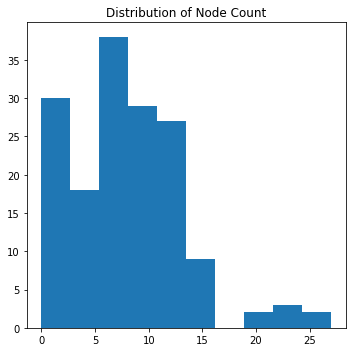

In [24]:
fig, axs = plt.subplots(figsize=(5,5),sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(cam_GLI_df['node_count'])
axs.set_title('Distribution of Node Count')


# 5) Simulations

### 5.A) Rhea Approach
#### Compare GLI from CAM with measures that would be expected from a randomly generated graph <br> assumption: graph probability distribution is uniform, conditioned on size

In [25]:
#Additional imports
import pymc3 as pm
import arviz as az
import random

/Users/agetecza/opt/anaconda3/envs/PythonEnv/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [26]:
cam_id = my_id_list[21] #Use only one to start
df_blocks = pd.read_csv(f'{my_filepath}/{cam_id}_blocks.csv')
links_df = pd.read_csv(f'{my_filepath}/{cam_id}_links.csv')
#df_blocks
df_blocks[df_blocks['shape']=='neutral'].count()[0]

2

In [27]:
# Create distance matrix
D = np.zeros((7,7))  # We have seven node types hence 7 (note that we consider ambivalent as the same as neutral in this calculation)
dist_ = np.arange(7)
for i in range(7):
    D[i,i:] = dist_
    D[i:,i] = dist_
    dist_ = dist_[:-1]

def calculate_diversity(D, probs):
    """
    Calculate Stirling Diversity measure with alpha = beta = 1
    Args:
        param: D - Distance Matrix
        param: probs - list of probabilities in order of Strong Negative, Negative, Weak Negative, Neutral, Weak Positive, Positive, Strong Positive
    """
    S = 0
    for i in range(7):
        for j in range(7):
            S += D[i, j]*probs[i]*probs[j]
    return S
# Get probabilities of each type of node -- used for diversity calculation
neg_strong = df_blocks[df_blocks['shape']=='negative strong'].count()[0]
neg = df_blocks[df_blocks['shape']=='negative'].count()[0]
neg_weak = df_blocks[df_blocks['shape']=='negative weak'].count()[0]
neutral = df_blocks[(df_blocks['shape']=='neutral') & (df_blocks['shape']=='ambivalent')].count()[0]
pos_weak = df_blocks[df_blocks['shape']=='positive weak'].count()[0]
pos = df_blocks[df_blocks['shape']=='positive'].count()[0]
pos_strong = df_blocks[df_blocks['shape']=='positive strong'].count()[0]
probs = [neg_strong, neg, neg_weak, neutral, pos_weak, pos, pos_strong]
true_div = calculate_diversity(D, probs)
print(true_div)

108.0


In [28]:
# Create n random graphs with the same number of nodes and edges
random_graphs = []

div_vals = []

n_ = 1000

for i in range(n_):
    random_graph = nx.gnm_random_graph(len(blocks_df), len(links_df))
    random_graphs.append(random_graph)
    
    # Get probabilities of each type of node -- used for diversity calculation
    neg_strong = df_blocks[df_blocks['shape']=='negative strong'].count()[0]
    neg = df_blocks[df_blocks['shape']=='negative'].count()[0]
    neg_weak = df_blocks[df_blocks['shape']=='negative weak'].count()[0]
    neutral = df_blocks[(df_blocks['shape']=='neutral') & (df_blocks['shape']=='ambivalent')].count()[0]
    pos_weak = df_blocks[df_blocks['shape']=='positive weak'].count()[0]
    pos = df_blocks[df_blocks['shape']=='positive'].count()[0]
    pos_strong = df_blocks[df_blocks['shape']=='positive strong'].count()[0]
    probs = [neg_strong, neg, neg_weak, neutral, pos_weak, pos, pos_strong]
    
    
    # Randomly assign valences to each node
    probs_rand = []
    for node in random_graph.nodes(data=True):
        shape_type_rand = random.choices([-3,-2,-1,0,1,2,3], weights=probs, k=1)[0]
        node[1]['shape_num'] = shape_type_rand
        probs_rand.append(shape_type_rand)
        
    # Calculate random graph node probabilities
    probs_rand = [probs_rand.count(-3), probs_rand.count(-2), probs_rand.count(-1), probs_rand.count(0), probs_rand.count(1), probs_rand.count(2), probs_rand.count(3)]
    
    # Calculate the diversity of each graph
    div_ = calculate_diversity(D, probs_rand)
    div_vals.append(div_)

In [29]:
# Calculate the number of instances with a similar diversity
insts_div = 0
for div_ in div_vals:
    if div_ - true_div < 100:
        insts_div += 1
    else:
        pass
print(insts_div)

182


In [ ]:
# Calculate probability of replicating using Bayesian stats
alphas = np.array([1, 1])
c = np.array([insts_div, n_-insts_div])

# Create model
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape=2)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=n_, p=parameters, shape=2, observed=c)    

In [59]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

/Users/agetecza/opt/anaconda3/envs/PythonEnv/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning:

In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.


In [60]:
print(az.summary(trace, kind="stats").mean)

/Users/agetecza/opt/anaconda3/envs/PythonEnv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



<bound method DataFrame.mean of                 mean     sd  hdi_3%  hdi_97%
parameters[0]  0.163  0.012   0.142    0.185
parameters[1]  0.837  0.012   0.815    0.858>


### 5.B) Anderson et al. Approach
#### Compare GLI from CAM with measures that would be expected from a randomly generated graph <br> assumption: graph probability distribution is uniform, conditioned on size and density
 (all graphs of given size and density are equally probable)

In [66]:
#Select only a few measures to test at first
col_list = list(cam_GLI_df.columns)
GLI_list = col_list[13:20]
GLI_list

['triadic_closure',
 'central_node',
 'central_node_title',
 'central_node_val',
 'central_node_val_eig',
 'central_node_val_bet']

In [70]:
GLI_name = GLI_list[4]

P_H = 0
P_L = 0
P_E = 0
N = 0 

N_max = 100 #number of iterations

alpha = .05 # desired level of significance

condition_list = []
sig_cam_list = []
nonsig_cam_list = []

for i in range(len(cam_GLI_df)):
    
    Obs_GLI = cam_GLI_df[GLI_name][i] #observed GLI from row i

    n = cam_GLI_df['node_count'][i] # number of nodes for cam i
    m = cam_GLI_df['edge_count'][i]  # number of edges for cam i

    while N < N_max:

        # STEP 2: Make the random graph
        G_uni = nx.gnm_random_graph(n, m)


        #Get the necessary GLI measures
        # Calculate Density
        density = np.round(nx.density(G_uni), 3)

        # Calculate longest path
        try:
            components = nx.connected_components(G_uni)
            largest_component = max(components, key=len)
            subgraph = G_uni.subgraph(largest_component)
            diameter = nx.diameter(subgraph)
        except:
            diameter = 0
        # Calculate transitivity
        triadic_closure = np.round(nx.transitivity(G_uni), 3)

        # Calculate max degree
        try:
            degree_centrality = nx.degree_centrality(G_uni)
            max_centrality_ind = np.argmax(list(degree_centrality.values()))
            central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val = 0

        # Eigenvector Centrality
        try:
            eigenvector_centrality = nx.eigenvector_centrality(G_uni)
            max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
            central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_eig = 0

        # Betweeness Centrality
        try:
            betweenness_centrality = nx.betweenness_centrality(G_uni)
            max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
            central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_bet = 0

        # Make the dictionary
        G_uni_GLI_dict = {
            'central_node_val': central_node_val,
            'central_node_val_eig': central_node_val_eig,
            'central_node_val_bet': central_node_val_bet
        }

        #STEP 3 - 
        
        if G_uni_GLI_dict[GLI_name] > Obs_GLI:
            P_H = P_H + 1

        elif G_uni_GLI_dict[GLI_name] < Obs_GLI:
            P_L = P_L +1

        #increment N for each iteration till max is reached
        N = N + 1

    #Step 5 - This tests whether the observed GLI is consistently either higher or lower than the GLI predicted
    # by a random graph. 
    condition_1 = (P_H/N_max) < (alpha/2)
    condition_2 = (P_L/N_max) < (alpha/2)
    
    condition_list.append((P_H/N_max, P_L/N_max))

    #Step 6 - generate a list of the cams that were sig and those that were not
    if condition_1 | condition_2:
        
        sig_cam_list.append(cam_GLI_df['cam_id'][i])
    
    else:
        nonsig_cam_list.append(cam_GLI_df['cam_id'][i])

In [76]:
#Percent of significant cams:
print(f'ration of nonsig:sig = {len(nonsig_cam_list)}:{len(sig_cam_list)}')

ration of nonsig:sig = 0:158


# 6) Combine Survey Info & CAM data

### 6.A) Bring in Survey Data

In [77]:
#Bring in survey data
file_path_survey = 'Your file path here'
survey_df = pd.read_csv(file_path_survey)
survey_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,WilsonPat_5,WilsonPat_6,WilsonPat_7,WilsonPat_8,WilsonPat_9,WilsonPat_10,WilsonPat_11,WilsonPat_12,CheckNum,mTurkCode2
0,2021-01-11 11:46,2021-01-11 11:46,0,50.69.196.183,100,8,1,2021-01-11 11:46,R_2ZQySv7eilk1BhL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-11 11:48,2021-01-11 11:59,0,50.69.196.183,100,660,1,2021-01-11 11:59,R_8erRxEBvfzDsLGp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-11 11:51,2021-01-11 12:01,0,69.158.246.27,100,635,1,2021-01-11 12:01,R_xgzbLgWncp56ACJ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-11 12:01,2021-01-11 12:13,0,24.212.224.202,100,739,1,2021-01-11 12:13,R_3rOr7B1NkrQgen5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-11 12:04,2021-01-11 12:18,0,24.77.79.89,100,820,1,2021-01-11 12:18,R_1KdKzGSFXHqdKef,NaN,...,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,8165033.0


In [78]:
#Count of survey
len(survey_df)

251

In [79]:
#drop NAs
survey_df_dropna = survey_df.dropna(subset=['Prolific1','Gender'])

### 6.B) Merge Survey with CAM data

In [80]:
#Get the cam dataframe ready to merge with the survey data
cam_GLI_full = cam_GLI_df.copy()
Prolific1_list=cam_GLI_full['cam_id'].str.split('_').str[0]
cam_GLI_full.insert(loc=0, column='Prolific1', value=Prolific1_list)
cam_GLI_full = cam_GLI_full.drop(cam_GLI_full.columns[1], axis=1)

In [81]:
print(f'The length of cam_df: {len(cam_GLI_full)}')
print(f'The length of survey_df: {len(survey_df_dropna)}')

The length of cam_df: 158
The length of survey_df: 141


In [82]:
survey_cam_merge = pd.merge(cam_GLI_full, survey_df_dropna, how = 'inner', on = 'Prolific1')

In [83]:
print(f'The length of merged data: {len(survey_cam_merge)}')

The length of merged data: 120


### 6.C) Cleaning the combined dataframe

#### Drop all rows with node_count less than 3 or link_count less than 2

In [84]:
filter_cam = (survey_cam_merge['node_count']>3) & (survey_cam_merge['edge_count']>2)
survey_merge_large_cam = survey_cam_merge[filter_cam]

In [85]:
print(f'{len(survey_merge_large_cam)} rows have more than 3 nodes and more than 2 edges')

113 rows have more than 3 nodes and more than 2 edges


#### Look for duplicates

In [87]:
survey_merge_large_cam = survey_merge_large_cam.reset_index(drop=True)

In [47]:
survey_merge_large_cam[survey_merge_large_cam.duplicated()]

,Prolific1,node_count,edge_count,node_diversity,node_valence_1,node_valence_2,density,diameter,triadic_closure,central_node,...,WilsonPat_5,WilsonPat_6,WilsonPat_7,WilsonPat_8,WilsonPat_9,WilsonPat_10,WilsonPat_11,WilsonPat_12,CheckNum,mTurkCode2
21,5f04cb284a1b587a33e1978d,14,15,2.530612,-1.14,-1.0,0.165,2,0.692,0,...,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,3646527.0


### 6.D) Export data 

In [86]:
#Export df with all the columns
survey_merge_large_cam.to_csv("/Users/agetecza/CAM_Data/AT_CAM/Data/clean_surveryCAM_df.csv", index = False)

# 7) Summary Statistics

### 7.A) Select Variables for Analysis

In [88]:
#Get list of all column/variables names
survey_column_list = list(survey_merge_large_cam.columns)
#survey_column_list

In [91]:
#Get all the controls
control_list_1 = ['Age','Education','Income','English','Gender','CarbFam','CarbSFam']
control_list_Cog = survey_column_list[108:126]
control_list_Aff = survey_column_list[126:152]
control_list_KN = survey_column_list[173:180]

control_list = control_list_1 + control_list_Aff + control_list_Cog + control_list_KN

In [94]:
summary_df = pd.DataFrame(survey_merge_large_cam[control_list_1].describe()).transpose()
summary_df

,count,mean,std,min,25%,50%,75%,max
Age,113.0,33.097345,10.363022,18.0,25.0,32.0,39.0,67.0
Education,113.0,5.690265,1.086275,2.0,5.0,6.0,6.0,8.0
Income,113.0,5.876106,2.882003,1.0,4.0,6.0,8.0,11.0
English,113.0,1.097345,0.297748,1.0,1.0,1.0,1.0,2.0
Gender,113.0,1.486726,0.502050,1.0,1.0,1.0,2.0,2.0
CarbFam,113.0,1.132743,0.472539,1.0,1.0,1.0,1.0,3.0
CarbSFam,113.0,3.212389,0.784348,1.0,3.0,3.0,4.0,5.0


In [96]:
#Get all variable
end_network_index = survey_column_list.index('central_node_val_bet')
network_list = survey_column_list[:end_network_index]
dependent_list = ['CarbAg','Interest_1','CarbDecide']
full_variable_list = network_list + dependent_list + control_list

# Assumption Testing 

In [97]:
#subset df 
survey_df_analysis = survey_merge_large_cam.loc[:,full_variable_list]

### Correlation 

In [98]:
len(survey_df_analysis)

113

In [99]:
#Clean up column order
#column_order = list(np.arange(0,21))+list(np.arange(47,50))+list(np.arange(65,68))+list(np.arange(24,47))+list(np.arange(50,65))+list(np.arange(21,24))+list(np.arange(68,72))
#survey_df_arrange = survey_df_analysis.iloc[:,column_order]
#survey_df_arrange.head()

In [100]:
correlation_matrix = survey_df_analysis.corr()

In [101]:
correlation_matrix.iloc[7,5]

0.017156800126020423

In [102]:
corr_df = pd.DataFrame(columns = ['row','column','corr'])
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix)):
        if (correlation_matrix.iloc[i,j]>.6) & (correlation_matrix.iloc[i,j]!=1):
            newrow = {'row':correlation_matrix.columns[i],'column':correlation_matrix.columns[j],'corr':correlation_matrix.iloc[i,j]}
            corr_df = corr_df.append(newrow, ignore_index=True)
            

In [103]:
corr_df

,row,column,corr
0,node_count,edge_count,0.842091
1,node_count,positive_nodes,0.759642
2,node_count,negative_nodes,0.738007
3,node_count,link_solid,0.845163
4,edge_count,node_count,0.842091
5,edge_count,positive_nodes,0.692700
6,edge_count,negative_nodes,0.607225
7,edge_count,link_solid,0.964363
8,positive_nodes,node_count,0.759642
9,positive_nodes,edge_count,0.692700


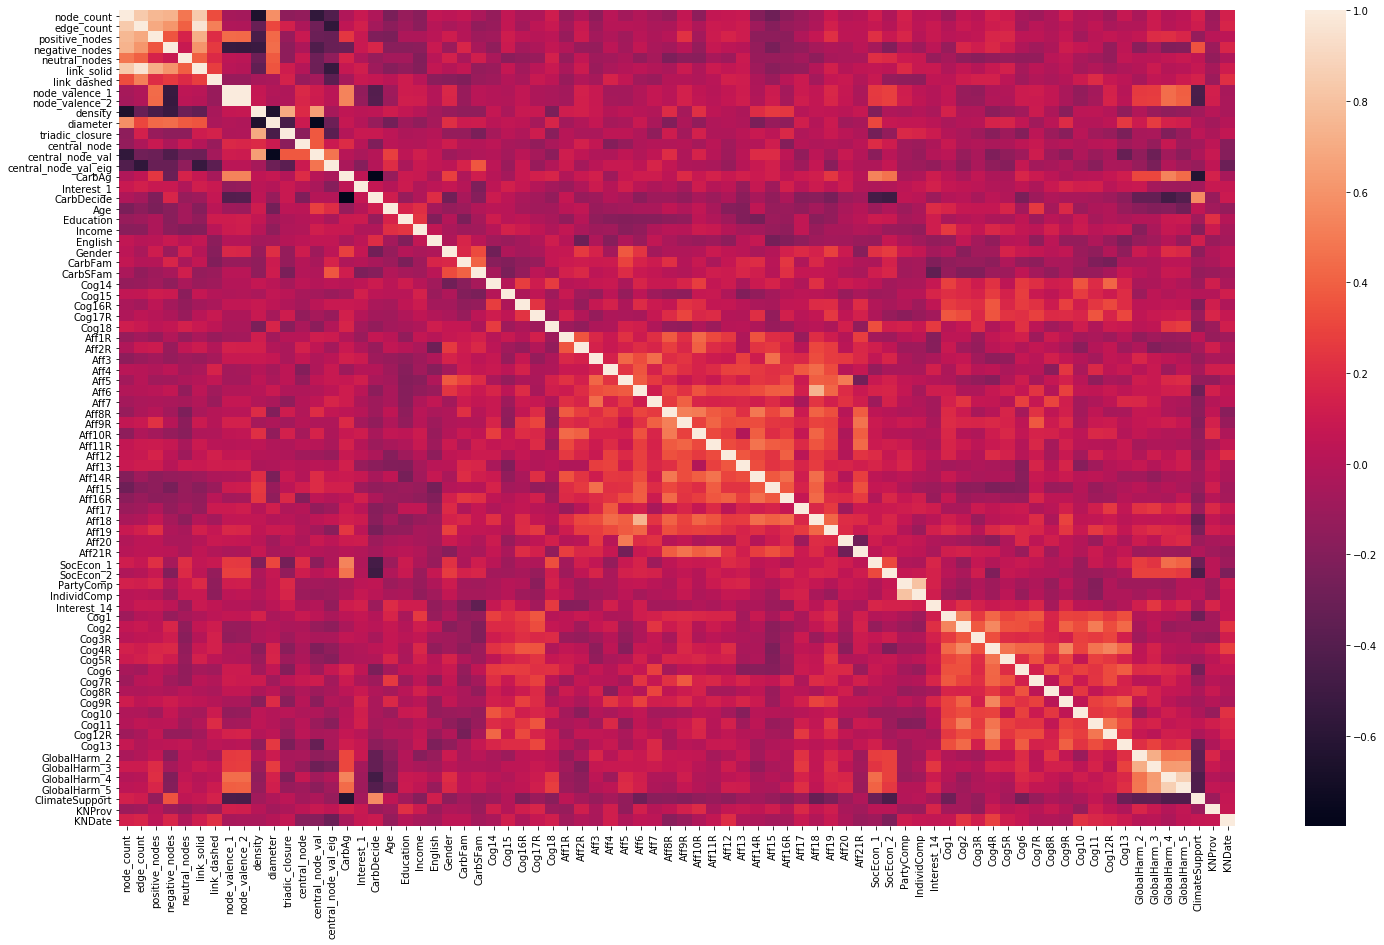

In [104]:
import seaborn as sns
plt.subplots(figsize=(25,15))
sns.heatmap(correlation_matrix)